## 2D Terzaghi Consolidation Problem (PINN)

In [1]:
import os
import numpy as np 
import sciann as sn 
import pandas as pd
import matplotlib.pyplot as plt

from scianndatagen import DataGeneratorXYT
from sciann.utils.math import sign, abs, sigmoid, tanh, diff

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.10.0 
Python Version: 3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)] 



In [2]:
s, minute, hr, day, year = 1., 60., 60.**2, 24*60.**2, 24*60.**2*365.25
mm, cm, m, km = 1e-3, 1e-2, 1.0, 1e3
Pa, kPa, MPa, GPa = 1.0, 1.e3, 1.e6, 1.e9

In [3]:
# ----------------------- Constant Parameters-------------------------
cx = 0.6 # m^2/year consolidation
cz = 1.0

Lx = 4*m
Ly = 4*m
p0 = 1.0*Pa
p_star = 1.0*Pa

x_min, y_min = 0.,0.
x_max, y_max = 4.0,4.0
t_min, t_max = 0.,1.0

NUM_SAMPLES = 10000

In [4]:
# ----------------------- Neural Network Setup -----------------------
sn.reset_session()
sn.set_random_seed(1234)

xd = sn.Variable('xd', dtype='float32')
yd = sn.Variable('yd', dtype='float32')
td = sn.Variable('td', dtype='float32')

pd = sn.Functional('pd', [xd, yd, td], 8*[20], 'tanh')

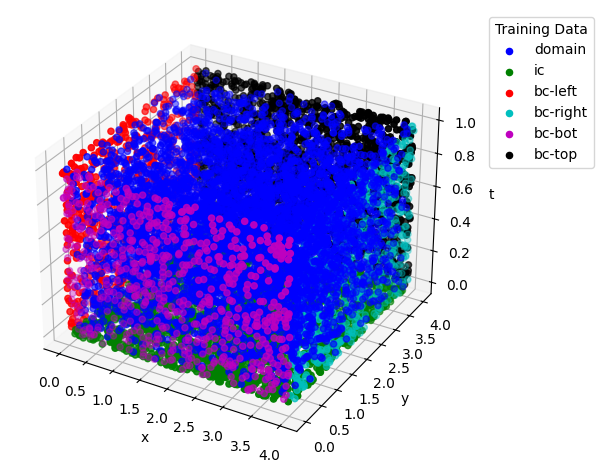

In [5]:
# Generate the training data
dg = DataGeneratorXYT(
    X=[x_min, x_max],
    Y=[y_min, y_max],
    T=[t_min, t_max],
    targets=['domain', 'ic', 'bc-left', 'bc-right', 'bc-bot', 'bc-top'],
    num_sample=NUM_SAMPLES,
)
dg.plot_data()

In [6]:
# 2D Terzaghi Consolidation Problem
pd_x, pd_y, pd_t = diff(pd, xd), diff(pd, yd), diff(pd, td)
pd_xx = diff(pd_x, xd)
pd_yy = diff(pd_y, yd)

# PDE Equation and BCs
PDE_2D = cx*pd_xx + cz*pd_yy - pd_t

bc_ini = (td == t_min) * abs(pd - p0/p_star)
bc_left = (xd == x_min) * abs(pd_x)
bc_right = (xd == x_max) * abs(pd)
bc_bot = (yd == y_min) * abs(pd_y)
bc_top = (yd == y_max) * abs(pd)

targets_2D = [sn.PDE(PDE_2D), bc_ini, bc_left, bc_right, bc_bot, bc_top]

input_data_2D, target_data_2D = dg.get_data()

In [7]:
adaptive_weights = {'method': 'NTK', 'freq':200}
epochs = 1000
batch_size = 500

initial_lr = 1e-3
final_lr = initial_lr/100

learning_rate = {
    "scheduler": "ExponentialDecay", 
    "initial_learning_rate": initial_lr,
    "final_learning_rate": final_lr, 
    "decay_epochs": epochs
}

In [8]:
train = True
load_weights = not train

# Create and train the model
model = sn.SciModel(
    [xd, yd, td],
    targets_2D,
    "mse",
    "Adam",
    load_weights_from = 'Terzaghi_2D_20k.hdf5' if load_weights else None 
)

if train:
    global H
    H = model.train(
        input_data_2D,
        target_data_2D,
        epochs=epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        stop_loss_value=1e-8,
        stop_after=None,
        verbose=2,
        adaptive_weights=adaptive_weights
    )
    model.save_weights('Terzaghi2Dtest_trained_weights.hdf5')


Total samples: 11250 
Batch size: 500 
Total batches: 23 


+ NTK evaluation time [s]: 5.848739147186279 

+ adaptive_weights at epoch 1: [0.3775197116123974, 0.3033513925600181, 1.1540909675154971, 0.9050529178355828, 2.9648380512282295, 0.2951469592482755]
Epoch 1/1000
23/23 - 3s - loss: 0.3046 - sub_loss: 0.0072 - mul_2_loss: 0.6747 - mul_3_loss: 0.0355 - mul_4_loss: 0.0314 - mul_5_loss: 0.0063 - mul_6_loss: 0.0255 - lr: 0.0010 - time: 9.9116 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 - loss_gradient_4: 45.5171 - loss_gradient_5: 248.6195 - 3s/epoch - 139ms/step
Epoch 2/1000
23/23 - 1s - loss: 0.2248 - sub_loss: 0.0048 - mul_2_loss: 0.5591 - mul_3_loss: 0.0012 - mul_4_loss: 0.0334 - mul_5_loss: 0.0011 - mul_6_loss: 0.0612 - lr: 9.9545e-04 - time: 0.5103 - loss_weight_0: 0.

Epoch 16/1000
23/23 - 1s - loss: 0.0559 - sub_loss: 0.0198 - mul_2_loss: 0.1047 - mul_3_loss: 4.3309e-04 - mul_4_loss: 0.0069 - mul_5_loss: 2.5065e-04 - mul_6_loss: 0.0316 - lr: 9.3325e-04 - time: 0.5703 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 - loss_gradient_4: 45.5171 - loss_gradient_5: 248.6195 - 570ms/epoch - 25ms/step
Epoch 17/1000
23/23 - 1s - loss: 0.0529 - sub_loss: 0.0176 - mul_2_loss: 0.0994 - mul_3_loss: 3.6192e-04 - mul_4_loss: 0.0066 - mul_5_loss: 2.1388e-04 - mul_6_loss: 0.0313 - lr: 9.2901e-04 - time: 0.5915 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876

Epoch 32/1000
23/23 - 1s - loss: 0.0314 - sub_loss: 0.0106 - mul_2_loss: 0.0552 - mul_3_loss: 1.2418e-04 - mul_4_loss: 0.0035 - mul_5_loss: 1.3791e-04 - mul_6_loss: 0.0230 - lr: 8.6700e-04 - time: 0.5140 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 - loss_gradient_4: 45.5171 - loss_gradient_5: 248.6195 - 514ms/epoch - 22ms/step
Epoch 33/1000
23/23 - 1s - loss: 0.0303 - sub_loss: 0.0108 - mul_2_loss: 0.0538 - mul_3_loss: 1.2665e-04 - mul_4_loss: 0.0038 - mul_5_loss: 6.5929e-05 - mul_6_loss: 0.0205 - lr: 8.6303e-04 - time: 0.5594 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876

Epoch 48/1000
23/23 - 1s - loss: 0.0304 - sub_loss: 0.0093 - mul_2_loss: 0.0495 - mul_3_loss: 1.1218e-04 - mul_4_loss: 0.0063 - mul_5_loss: 7.2352e-05 - mul_6_loss: 0.0198 - lr: 8.0543e-04 - time: 0.5404 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 - loss_gradient_4: 45.5171 - loss_gradient_5: 248.6195 - 539ms/epoch - 23ms/step
Epoch 49/1000
23/23 - 1s - loss: 0.0257 - sub_loss: 0.0095 - mul_2_loss: 0.0442 - mul_3_loss: 1.1502e-04 - mul_4_loss: 0.0035 - mul_5_loss: 5.6224e-05 - mul_6_loss: 0.0171 - lr: 8.0173e-04 - time: 0.6143 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876

Epoch 64/1000
23/23 - 1s - loss: 0.0234 - sub_loss: 0.0092 - mul_2_loss: 0.0390 - mul_3_loss: 9.6356e-05 - mul_4_loss: 0.0035 - mul_5_loss: 5.5176e-05 - mul_6_loss: 0.0157 - lr: 7.4822e-04 - time: 0.5625 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 - loss_gradient_4: 45.5171 - loss_gradient_5: 248.6195 - 564ms/epoch - 25ms/step
Epoch 65/1000
23/23 - 1s - loss: 0.0252 - sub_loss: 0.0095 - mul_2_loss: 0.0377 - mul_3_loss: 1.1020e-04 - mul_4_loss: 0.0058 - mul_5_loss: 6.0061e-05 - mul_6_loss: 0.0152 - lr: 7.4476e-04 - time: 0.5683 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876

Epoch 80/1000
23/23 - 1s - loss: 0.0206 - sub_loss: 0.0081 - mul_2_loss: 0.0340 - mul_3_loss: 9.4454e-05 - mul_4_loss: 0.0034 - mul_5_loss: 3.6260e-05 - mul_6_loss: 0.0130 - lr: 6.9505e-04 - time: 0.5822 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 - loss_gradient_4: 45.5171 - loss_gradient_5: 248.6195 - 582ms/epoch - 25ms/step
Epoch 81/1000
23/23 - 1s - loss: 0.0211 - sub_loss: 0.0077 - mul_2_loss: 0.0338 - mul_3_loss: 9.9540e-05 - mul_4_loss: 0.0040 - mul_5_loss: 4.5005e-05 - mul_6_loss: 0.0140 - lr: 6.9183e-04 - time: 0.5272 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876

Epoch 96/1000
23/23 - 1s - loss: 0.0212 - sub_loss: 0.0079 - mul_2_loss: 0.0315 - mul_3_loss: 1.1248e-04 - mul_4_loss: 0.0047 - mul_5_loss: 5.2806e-05 - mul_6_loss: 0.0138 - lr: 6.4565e-04 - time: 0.5838 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 - loss_gradient_4: 45.5171 - loss_gradient_5: 248.6195 - 585ms/epoch - 25ms/step
Epoch 97/1000
23/23 - 1s - loss: 0.0188 - sub_loss: 0.0073 - mul_2_loss: 0.0309 - mul_3_loss: 1.2606e-04 - mul_4_loss: 0.0033 - mul_5_loss: 5.7643e-05 - mul_6_loss: 0.0118 - lr: 6.4271e-04 - time: 0.6085 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876

Epoch 112/1000
23/23 - 2s - loss: 0.0171 - sub_loss: 0.0073 - mul_2_loss: 0.0263 - mul_3_loss: 1.0055e-04 - mul_4_loss: 0.0032 - mul_5_loss: 2.9202e-05 - mul_6_loss: 0.0105 - lr: 5.9982e-04 - time: 2.2747 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 - loss_gradient_4: 45.5171 - loss_gradient_5: 248.6195 - 2s/epoch - 99ms/step
Epoch 113/1000
23/23 - 1s - loss: 0.0163 - sub_loss: 0.0068 - mul_2_loss: 0.0256 - mul_3_loss: 9.3238e-05 - mul_4_loss: 0.0026 - mul_5_loss: 4.1594e-05 - mul_6_loss: 0.0111 - lr: 5.9707e-04 - time: 0.5318 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 

Epoch 128/1000
23/23 - 1s - loss: 0.0164 - sub_loss: 0.0075 - mul_2_loss: 0.0239 - mul_3_loss: 9.1874e-05 - mul_4_loss: 0.0034 - mul_5_loss: 3.9840e-05 - mul_6_loss: 0.0104 - lr: 5.5722e-04 - time: 0.5479 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 - loss_gradient_4: 45.5171 - loss_gradient_5: 248.6195 - 548ms/epoch - 24ms/step
Epoch 129/1000
23/23 - 2s - loss: 0.0161 - sub_loss: 0.0070 - mul_2_loss: 0.0239 - mul_3_loss: 1.0442e-04 - mul_4_loss: 0.0029 - mul_5_loss: 3.9242e-05 - mul_6_loss: 0.0110 - lr: 5.5466e-04 - time: 2.1831 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.08

Epoch 144/1000
23/23 - 1s - loss: 0.0158 - sub_loss: 0.0064 - mul_2_loss: 0.0232 - mul_3_loss: 9.1733e-05 - mul_4_loss: 0.0031 - mul_5_loss: 5.3692e-05 - mul_6_loss: 0.0111 - lr: 5.1764e-04 - time: 0.6100 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 - loss_gradient_4: 45.5171 - loss_gradient_5: 248.6195 - 610ms/epoch - 27ms/step
Epoch 145/1000
23/23 - 2s - loss: 0.0142 - sub_loss: 0.0064 - mul_2_loss: 0.0211 - mul_3_loss: 8.8054e-05 - mul_4_loss: 0.0026 - mul_5_loss: 3.8130e-05 - mul_6_loss: 0.0095 - lr: 5.1525e-04 - time: 2.1447 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.08

Epoch 160/1000
23/23 - 2s - loss: 0.0145 - sub_loss: 0.0066 - mul_2_loss: 0.0195 - mul_3_loss: 8.0976e-05 - mul_4_loss: 0.0028 - mul_5_loss: 5.8609e-05 - mul_6_loss: 0.0111 - lr: 4.8086e-04 - time: 2.2922 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 - loss_gradient_4: 45.5171 - loss_gradient_5: 248.6195 - 2s/epoch - 100ms/step
Epoch 161/1000
23/23 - 1s - loss: 0.0141 - sub_loss: 0.0065 - mul_2_loss: 0.0213 - mul_3_loss: 7.3822e-05 - mul_4_loss: 0.0025 - mul_5_loss: 3.0477e-05 - mul_6_loss: 0.0089 - lr: 4.7863e-04 - time: 0.5795 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876

Epoch 176/1000
23/23 - 2s - loss: 0.0135 - sub_loss: 0.0061 - mul_2_loss: 0.0203 - mul_3_loss: 9.2034e-05 - mul_4_loss: 0.0026 - mul_5_loss: 2.9018e-05 - mul_6_loss: 0.0089 - lr: 4.4668e-04 - time: 2.2582 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 - loss_gradient_4: 45.5171 - loss_gradient_5: 248.6195 - 2s/epoch - 98ms/step
Epoch 177/1000
23/23 - 1s - loss: 0.0131 - sub_loss: 0.0057 - mul_2_loss: 0.0197 - mul_3_loss: 7.0093e-05 - mul_4_loss: 0.0023 - mul_5_loss: 4.2276e-05 - mul_6_loss: 0.0091 - lr: 4.4465e-04 - time: 0.6281 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 

Epoch 192/1000
23/23 - 0s - loss: 0.0135 - sub_loss: 0.0064 - mul_2_loss: 0.0189 - mul_3_loss: 8.4574e-05 - mul_4_loss: 0.0023 - mul_5_loss: 3.6210e-05 - mul_6_loss: 0.0099 - lr: 4.1497e-04 - time: 0.4960 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.0876 - loss_gradient_4: 45.5171 - loss_gradient_5: 248.6195 - 496ms/epoch - 22ms/step
Epoch 193/1000
23/23 - 1s - loss: 0.0138 - sub_loss: 0.0060 - mul_2_loss: 0.0181 - mul_3_loss: 7.0899e-05 - mul_4_loss: 0.0032 - mul_5_loss: 5.3155e-05 - mul_6_loss: 0.0095 - lr: 4.1307e-04 - time: 0.5166 - loss_weight_0: 0.3775 - loss_weight_1: 0.3034 - loss_weight_2: 1.1541 - loss_weight_3: 0.9051 - loss_weight_4: 2.9648 - loss_weight_5: 0.2951 - loss_gradient_0: 197.7842 - loss_gradient_1: 234.3505 - loss_gradient_2: 116.8315 - loss_gradient_3: 118.08

Epoch 207/1000
23/23 - 1s - loss: 0.0018 - sub_loss: 0.0054 - mul_2_loss: 0.0155 - mul_3_loss: 4.8057e-05 - mul_4_loss: 0.0018 - mul_5_loss: 2.3535e-05 - mul_6_loss: 0.0091 - lr: 3.8727e-04 - time: 0.5846 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss_gradient_4: 270.8517 - loss_gradient_5: 9319.1111 - 585ms/epoch - 25ms/step
Epoch 208/1000
23/23 - 0s - loss: 0.0018 - sub_loss: 0.0053 - mul_2_loss: 0.0159 - mul_3_loss: 5.0793e-05 - mul_4_loss: 0.0020 - mul_5_loss: 2.1828e-05 - mul_6_loss: 0.0085 - lr: 3.8550e-04 - time: 0.4918 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9

23/23 - 1s - loss: 0.0018 - sub_loss: 0.0055 - mul_2_loss: 0.0150 - mul_3_loss: 5.1188e-05 - mul_4_loss: 0.0022 - mul_5_loss: 2.2693e-05 - mul_6_loss: 0.0084 - lr: 3.6143e-04 - time: 0.5658 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss_gradient_4: 270.8517 - loss_gradient_5: 9319.1111 - 566ms/epoch - 25ms/step
Epoch 223/1000
23/23 - 1s - loss: 0.0018 - sub_loss: 0.0054 - mul_2_loss: 0.0154 - mul_3_loss: 3.7242e-05 - mul_4_loss: 0.0019 - mul_5_loss: 2.1569e-05 - mul_6_loss: 0.0093 - lr: 3.5977e-04 - time: 0.5158 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss

Epoch 238/1000
23/23 - 1s - loss: 0.0017 - sub_loss: 0.0059 - mul_2_loss: 0.0144 - mul_3_loss: 3.0881e-05 - mul_4_loss: 0.0021 - mul_5_loss: 2.0346e-05 - mul_6_loss: 0.0093 - lr: 3.3576e-04 - time: 0.5172 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss_gradient_4: 270.8517 - loss_gradient_5: 9319.1111 - 517ms/epoch - 22ms/step
Epoch 239/1000
23/23 - 0s - loss: 0.0017 - sub_loss: 0.0055 - mul_2_loss: 0.0148 - mul_3_loss: 3.1442e-05 - mul_4_loss: 0.0020 - mul_5_loss: 1.9220e-05 - mul_6_loss: 0.0088 - lr: 3.3422e-04 - time: 0.4945 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9

23/23 - 1s - loss: 0.0018 - sub_loss: 0.0059 - mul_2_loss: 0.0136 - mul_3_loss: 2.9842e-05 - mul_4_loss: 0.0026 - mul_5_loss: 2.6208e-05 - mul_6_loss: 0.0097 - lr: 3.1335e-04 - time: 0.5270 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss_gradient_4: 270.8517 - loss_gradient_5: 9319.1111 - 527ms/epoch - 23ms/step
Epoch 254/1000
23/23 - 0s - loss: 0.0017 - sub_loss: 0.0056 - mul_2_loss: 0.0159 - mul_3_loss: 2.8675e-05 - mul_4_loss: 0.0018 - mul_5_loss: 1.9431e-05 - mul_6_loss: 0.0088 - lr: 3.1191e-04 - time: 0.4946 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss

Epoch 269/1000
23/23 - 1s - loss: 0.0017 - sub_loss: 0.0053 - mul_2_loss: 0.0146 - mul_3_loss: 2.1175e-05 - mul_4_loss: 0.0022 - mul_5_loss: 3.5155e-05 - mul_6_loss: 0.0093 - lr: 2.9109e-04 - time: 0.5918 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss_gradient_4: 270.8517 - loss_gradient_5: 9319.1111 - 592ms/epoch - 26ms/step
Epoch 270/1000
23/23 - 1s - loss: 0.0017 - sub_loss: 0.0058 - mul_2_loss: 0.0139 - mul_3_loss: 1.9801e-05 - mul_4_loss: 0.0021 - mul_5_loss: 2.6387e-05 - mul_6_loss: 0.0088 - lr: 2.8975e-04 - time: 0.5239 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9

23/23 - 1s - loss: 0.0016 - sub_loss: 0.0057 - mul_2_loss: 0.0137 - mul_3_loss: 1.5515e-05 - mul_4_loss: 0.0020 - mul_5_loss: 1.8983e-05 - mul_6_loss: 0.0092 - lr: 2.7166e-04 - time: 0.5017 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss_gradient_4: 270.8517 - loss_gradient_5: 9319.1111 - 502ms/epoch - 22ms/step
Epoch 285/1000
23/23 - 1s - loss: 0.0016 - sub_loss: 0.0056 - mul_2_loss: 0.0144 - mul_3_loss: 1.8749e-05 - mul_4_loss: 0.0018 - mul_5_loss: 2.3833e-05 - mul_6_loss: 0.0092 - lr: 2.7041e-04 - time: 0.5106 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss

Epoch 300/1000
23/23 - 0s - loss: 0.0016 - sub_loss: 0.0056 - mul_2_loss: 0.0139 - mul_3_loss: 1.5018e-05 - mul_4_loss: 0.0020 - mul_5_loss: 1.6810e-05 - mul_6_loss: 0.0091 - lr: 2.5236e-04 - time: 0.4797 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss_gradient_4: 270.8517 - loss_gradient_5: 9319.1111 - 480ms/epoch - 21ms/step
Epoch 301/1000
23/23 - 0s - loss: 0.0016 - sub_loss: 0.0054 - mul_2_loss: 0.0148 - mul_3_loss: 1.2650e-05 - mul_4_loss: 0.0019 - mul_5_loss: 2.2490e-05 - mul_6_loss: 0.0091 - lr: 2.5119e-04 - time: 0.4703 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9

23/23 - 1s - loss: 0.0016 - sub_loss: 0.0053 - mul_2_loss: 0.0140 - mul_3_loss: 1.1255e-05 - mul_4_loss: 0.0022 - mul_5_loss: 1.7615e-05 - mul_6_loss: 0.0094 - lr: 2.3551e-04 - time: 0.5044 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss_gradient_4: 270.8517 - loss_gradient_5: 9319.1111 - 504ms/epoch - 22ms/step
Epoch 316/1000
23/23 - 1s - loss: 0.0016 - sub_loss: 0.0058 - mul_2_loss: 0.0145 - mul_3_loss: 1.0615e-05 - mul_4_loss: 0.0018 - mul_5_loss: 1.5177e-05 - mul_6_loss: 0.0085 - lr: 2.3442e-04 - time: 0.5258 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss

Epoch 331/1000
23/23 - 1s - loss: 0.0016 - sub_loss: 0.0053 - mul_2_loss: 0.0153 - mul_3_loss: 1.0497e-05 - mul_4_loss: 0.0015 - mul_5_loss: 2.1183e-05 - mul_6_loss: 0.0090 - lr: 2.1878e-04 - time: 0.5078 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss_gradient_4: 270.8517 - loss_gradient_5: 9319.1111 - 508ms/epoch - 22ms/step
Epoch 332/1000
23/23 - 1s - loss: 0.0017 - sub_loss: 0.0059 - mul_2_loss: 0.0134 - mul_3_loss: 1.3478e-05 - mul_4_loss: 0.0029 - mul_5_loss: 2.0015e-05 - mul_6_loss: 0.0092 - lr: 2.1778e-04 - time: 0.5006 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9

23/23 - 0s - loss: 0.0015 - sub_loss: 0.0054 - mul_2_loss: 0.0133 - mul_3_loss: 1.0273e-05 - mul_4_loss: 0.0019 - mul_5_loss: 1.7017e-05 - mul_6_loss: 0.0086 - lr: 2.0417e-04 - time: 0.4963 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss_gradient_4: 270.8517 - loss_gradient_5: 9319.1111 - 496ms/epoch - 22ms/step
Epoch 347/1000
23/23 - 1s - loss: 0.0016 - sub_loss: 0.0055 - mul_2_loss: 0.0137 - mul_3_loss: 1.1609e-05 - mul_4_loss: 0.0019 - mul_5_loss: 1.7680e-05 - mul_6_loss: 0.0087 - lr: 2.0324e-04 - time: 0.5057 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss

Epoch 362/1000
23/23 - 1s - loss: 0.0016 - sub_loss: 0.0055 - mul_2_loss: 0.0138 - mul_3_loss: 7.3862e-06 - mul_4_loss: 0.0022 - mul_5_loss: 1.4196e-05 - mul_6_loss: 0.0087 - lr: 1.8968e-04 - time: 0.5395 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss_gradient_4: 270.8517 - loss_gradient_5: 9319.1111 - 540ms/epoch - 23ms/step
Epoch 363/1000
23/23 - 1s - loss: 0.0016 - sub_loss: 0.0052 - mul_2_loss: 0.0143 - mul_3_loss: 7.4577e-06 - mul_4_loss: 0.0025 - mul_5_loss: 1.6133e-05 - mul_6_loss: 0.0088 - lr: 1.8881e-04 - time: 0.5866 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9

23/23 - 1s - loss: 0.0015 - sub_loss: 0.0051 - mul_2_loss: 0.0133 - mul_3_loss: 5.9076e-06 - mul_4_loss: 0.0022 - mul_5_loss: 1.1730e-05 - mul_6_loss: 0.0090 - lr: 1.7702e-04 - time: 0.5575 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss_gradient_4: 270.8517 - loss_gradient_5: 9319.1111 - 557ms/epoch - 24ms/step
Epoch 378/1000
23/23 - 1s - loss: 0.0015 - sub_loss: 0.0055 - mul_2_loss: 0.0129 - mul_3_loss: 4.7334e-06 - mul_4_loss: 0.0020 - mul_5_loss: 1.2691e-05 - mul_6_loss: 0.0082 - lr: 1.7621e-04 - time: 0.5820 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss

Epoch 393/1000
23/23 - 1s - loss: 0.0016 - sub_loss: 0.0057 - mul_2_loss: 0.0130 - mul_3_loss: 4.3430e-06 - mul_4_loss: 0.0021 - mul_5_loss: 1.6791e-05 - mul_6_loss: 0.0093 - lr: 1.6445e-04 - time: 0.5827 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9749.0494 - loss_gradient_4: 270.8517 - loss_gradient_5: 9319.1111 - 583ms/epoch - 25ms/step
Epoch 394/1000
23/23 - 1s - loss: 0.0016 - sub_loss: 0.0055 - mul_2_loss: 0.0135 - mul_3_loss: 7.6669e-06 - mul_4_loss: 0.0024 - mul_5_loss: 1.9600e-05 - mul_6_loss: 0.0082 - lr: 1.6369e-04 - time: 0.5715 - loss_weight_0: 0.0495 - loss_weight_1: 0.0491 - loss_weight_2: 4.5594 - loss_weight_3: 0.1072 - loss_weight_4: 1.1960 - loss_weight_5: 0.0389 - loss_gradient_0: 8779.9332 - loss_gradient_1: 9850.4736 - loss_gradient_2: 34.5331 - loss_gradient_3: 9

Epoch 408/1000
23/23 - 1s - loss: 4.5744e-04 - sub_loss: 0.0056 - mul_2_loss: 0.0104 - mul_3_loss: 3.4255e-06 - mul_4_loss: 0.0024 - mul_5_loss: 1.1820e-05 - mul_6_loss: 0.0089 - lr: 1.5347e-04 - time: 0.5726 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gradient_3: 10104.5692 - loss_gradient_4: 277.0508 - loss_gradient_5: 9938.6003 - 573ms/epoch - 25ms/step
Epoch 409/1000
23/23 - 1s - loss: 4.6521e-04 - sub_loss: 0.0057 - mul_2_loss: 0.0093 - mul_3_loss: 3.3865e-06 - mul_4_loss: 0.0030 - mul_5_loss: 1.2436e-05 - mul_6_loss: 0.0097 - lr: 1.5277e-04 - time: 0.5813 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gr

Epoch 423/1000
23/23 - 0s - loss: 4.6584e-04 - sub_loss: 0.0056 - mul_2_loss: 0.0108 - mul_3_loss: 3.7345e-06 - mul_4_loss: 0.0021 - mul_5_loss: 1.2384e-05 - mul_6_loss: 0.0090 - lr: 1.4323e-04 - time: 0.4943 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gradient_3: 10104.5692 - loss_gradient_4: 277.0508 - loss_gradient_5: 9938.6003 - 494ms/epoch - 21ms/step
Epoch 424/1000
23/23 - 1s - loss: 4.6236e-04 - sub_loss: 0.0054 - mul_2_loss: 0.0096 - mul_3_loss: 4.4131e-06 - mul_4_loss: 0.0025 - mul_5_loss: 1.0876e-05 - mul_6_loss: 0.0094 - lr: 1.4257e-04 - time: 0.5004 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gr

Epoch 438/1000
23/23 - 1s - loss: 4.4793e-04 - sub_loss: 0.0057 - mul_2_loss: 0.0096 - mul_3_loss: 2.2039e-06 - mul_4_loss: 0.0027 - mul_5_loss: 9.8648e-06 - mul_6_loss: 0.0095 - lr: 1.3367e-04 - time: 0.5699 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gradient_3: 10104.5692 - loss_gradient_4: 277.0508 - loss_gradient_5: 9938.6003 - 571ms/epoch - 25ms/step
Epoch 439/1000
23/23 - 1s - loss: 4.4775e-04 - sub_loss: 0.0052 - mul_2_loss: 0.0101 - mul_3_loss: 2.3902e-06 - mul_4_loss: 0.0023 - mul_5_loss: 1.1573e-05 - mul_6_loss: 0.0095 - lr: 1.3305e-04 - time: 0.5625 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gr

Epoch 453/1000
23/23 - 0s - loss: 4.4667e-04 - sub_loss: 0.0063 - mul_2_loss: 0.0091 - mul_3_loss: 2.1599e-06 - mul_4_loss: 0.0028 - mul_5_loss: 1.0079e-05 - mul_6_loss: 0.0089 - lr: 1.2475e-04 - time: 0.4785 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gradient_3: 10104.5692 - loss_gradient_4: 277.0508 - loss_gradient_5: 9938.6003 - 477ms/epoch - 21ms/step
Epoch 454/1000
23/23 - 0s - loss: 4.5175e-04 - sub_loss: 0.0054 - mul_2_loss: 0.0108 - mul_3_loss: 1.9766e-06 - mul_4_loss: 0.0022 - mul_5_loss: 9.5592e-06 - mul_6_loss: 0.0092 - lr: 1.2417e-04 - time: 0.4816 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gr

Epoch 468/1000
23/23 - 1s - loss: 4.5592e-04 - sub_loss: 0.0060 - mul_2_loss: 0.0093 - mul_3_loss: 1.9163e-06 - mul_4_loss: 0.0026 - mul_5_loss: 1.7816e-05 - mul_6_loss: 0.0096 - lr: 1.1642e-04 - time: 0.5877 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gradient_3: 10104.5692 - loss_gradient_4: 277.0508 - loss_gradient_5: 9938.6003 - 588ms/epoch - 26ms/step
Epoch 469/1000
23/23 - 0s - loss: 4.5215e-04 - sub_loss: 0.0058 - mul_2_loss: 0.0097 - mul_3_loss: 1.9657e-06 - mul_4_loss: 0.0025 - mul_5_loss: 1.1687e-05 - mul_6_loss: 0.0092 - lr: 1.1589e-04 - time: 0.4887 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gr

Epoch 483/1000
23/23 - 1s - loss: 4.3668e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0096 - mul_3_loss: 1.3690e-06 - mul_4_loss: 0.0024 - mul_5_loss: 9.8830e-06 - mul_6_loss: 0.0098 - lr: 1.0865e-04 - time: 0.5097 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gradient_3: 10104.5692 - loss_gradient_4: 277.0508 - loss_gradient_5: 9938.6003 - 510ms/epoch - 22ms/step
Epoch 484/1000
23/23 - 1s - loss: 4.3848e-04 - sub_loss: 0.0057 - mul_2_loss: 0.0090 - mul_3_loss: 1.5551e-06 - mul_4_loss: 0.0029 - mul_5_loss: 8.6871e-06 - mul_6_loss: 0.0086 - lr: 1.0815e-04 - time: 0.5090 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gr

Epoch 498/1000
23/23 - 1s - loss: 4.3551e-04 - sub_loss: 0.0057 - mul_2_loss: 0.0090 - mul_3_loss: 2.4709e-06 - mul_4_loss: 0.0027 - mul_5_loss: 7.8975e-06 - mul_6_loss: 0.0091 - lr: 1.0140e-04 - time: 0.5738 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gradient_3: 10104.5692 - loss_gradient_4: 277.0508 - loss_gradient_5: 9938.6003 - 574ms/epoch - 25ms/step
Epoch 499/1000
23/23 - 1s - loss: 4.4238e-04 - sub_loss: 0.0055 - mul_2_loss: 0.0095 - mul_3_loss: 2.1629e-06 - mul_4_loss: 0.0024 - mul_5_loss: 8.2582e-06 - mul_6_loss: 0.0091 - lr: 1.0093e-04 - time: 0.5525 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gr

Epoch 513/1000
23/23 - 0s - loss: 4.3473e-04 - sub_loss: 0.0050 - mul_2_loss: 0.0104 - mul_3_loss: 1.3018e-06 - mul_4_loss: 0.0024 - mul_5_loss: 1.1473e-05 - mul_6_loss: 0.0079 - lr: 9.4630e-05 - time: 0.4911 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gradient_3: 10104.5692 - loss_gradient_4: 277.0508 - loss_gradient_5: 9938.6003 - 491ms/epoch - 21ms/step
Epoch 514/1000
23/23 - 1s - loss: 4.3315e-04 - sub_loss: 0.0058 - mul_2_loss: 0.0097 - mul_3_loss: 1.1285e-06 - mul_4_loss: 0.0024 - mul_5_loss: 7.8428e-06 - mul_6_loss: 0.0087 - lr: 9.4195e-05 - time: 0.5682 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gr

Epoch 528/1000
23/23 - 1s - loss: 4.2758e-04 - sub_loss: 0.0058 - mul_2_loss: 0.0089 - mul_3_loss: 1.2948e-06 - mul_4_loss: 0.0028 - mul_5_loss: 8.1028e-06 - mul_6_loss: 0.0086 - lr: 8.8314e-05 - time: 0.5606 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gradient_3: 10104.5692 - loss_gradient_4: 277.0508 - loss_gradient_5: 9938.6003 - 561ms/epoch - 24ms/step
Epoch 529/1000
23/23 - 1s - loss: 4.2154e-04 - sub_loss: 0.0058 - mul_2_loss: 0.0088 - mul_3_loss: 9.8412e-07 - mul_4_loss: 0.0024 - mul_5_loss: 7.5810e-06 - mul_6_loss: 0.0092 - lr: 8.7908e-05 - time: 0.5219 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gr

Epoch 543/1000
23/23 - 1s - loss: 4.5706e-04 - sub_loss: 0.0058 - mul_2_loss: 0.0089 - mul_3_loss: 4.4448e-06 - mul_4_loss: 0.0031 - mul_5_loss: 1.0961e-05 - mul_6_loss: 0.0091 - lr: 8.2419e-05 - time: 0.5033 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gradient_3: 10104.5692 - loss_gradient_4: 277.0508 - loss_gradient_5: 9938.6003 - 503ms/epoch - 22ms/step
Epoch 544/1000
23/23 - 1s - loss: 4.2965e-04 - sub_loss: 0.0057 - mul_2_loss: 0.0087 - mul_3_loss: 2.8172e-06 - mul_4_loss: 0.0027 - mul_5_loss: 7.3103e-06 - mul_6_loss: 0.0087 - lr: 8.2040e-05 - time: 0.5058 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gr

Epoch 558/1000
23/23 - 1s - loss: 4.2307e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0093 - mul_3_loss: 1.3137e-06 - mul_4_loss: 0.0025 - mul_5_loss: 9.0245e-06 - mul_6_loss: 0.0089 - lr: 7.6918e-05 - time: 0.5787 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gradient_3: 10104.5692 - loss_gradient_4: 277.0508 - loss_gradient_5: 9938.6003 - 579ms/epoch - 25ms/step
Epoch 559/1000
23/23 - 0s - loss: 4.1953e-04 - sub_loss: 0.0060 - mul_2_loss: 0.0082 - mul_3_loss: 9.7380e-07 - mul_4_loss: 0.0027 - mul_5_loss: 9.3048e-06 - mul_6_loss: 0.0086 - lr: 7.6565e-05 - time: 0.4975 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gr

Epoch 573/1000
23/23 - 1s - loss: 4.3426e-04 - sub_loss: 0.0057 - mul_2_loss: 0.0092 - mul_3_loss: 2.6830e-06 - mul_4_loss: 0.0027 - mul_5_loss: 8.7481e-06 - mul_6_loss: 0.0085 - lr: 7.1784e-05 - time: 0.6415 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gradient_3: 10104.5692 - loss_gradient_4: 277.0508 - loss_gradient_5: 9938.6003 - 641ms/epoch - 28ms/step
Epoch 574/1000
23/23 - 1s - loss: 4.2653e-04 - sub_loss: 0.0054 - mul_2_loss: 0.0088 - mul_3_loss: 1.7675e-06 - mul_4_loss: 0.0028 - mul_5_loss: 1.1279e-05 - mul_6_loss: 0.0084 - lr: 7.1454e-05 - time: 0.5587 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gr

Epoch 588/1000
23/23 - 0s - loss: 4.1157e-04 - sub_loss: 0.0058 - mul_2_loss: 0.0089 - mul_3_loss: 1.0746e-06 - mul_4_loss: 0.0023 - mul_5_loss: 7.3288e-06 - mul_6_loss: 0.0086 - lr: 6.6993e-05 - time: 0.4997 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gradient_3: 10104.5692 - loss_gradient_4: 277.0508 - loss_gradient_5: 9938.6003 - 499ms/epoch - 22ms/step
Epoch 589/1000
23/23 - 1s - loss: 4.0533e-04 - sub_loss: 0.0051 - mul_2_loss: 0.0088 - mul_3_loss: 9.7472e-07 - mul_4_loss: 0.0021 - mul_5_loss: 8.0487e-06 - mul_6_loss: 0.0095 - lr: 6.6685e-05 - time: 0.5174 - loss_weight_0: 0.0142 - loss_weight_1: 0.0187 - loss_weight_2: 5.0826 - loss_weight_3: 0.0242 - loss_weight_4: 0.8489 - loss_weight_5: 0.0114 - loss_gradient_0: 8264.2128 - loss_gradient_1: 11586.9919 - loss_gradient_2: 26.3781 - loss_gr

Epoch 603/1000
23/23 - 1s - loss: 2.7734e-04 - sub_loss: 0.0054 - mul_2_loss: 0.0080 - mul_3_loss: 8.8235e-07 - mul_4_loss: 0.0028 - mul_5_loss: 1.0687e-05 - mul_6_loss: 0.0086 - lr: 6.2521e-05 - time: 0.5085 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_gradient_3: 10956.6290 - loss_gradient_4: 296.4634 - loss_gradient_5: 11143.3656 - 507ms/epoch - 22ms/step
Epoch 604/1000
23/23 - 1s - loss: 2.7378e-04 - sub_loss: 0.0052 - mul_2_loss: 0.0081 - mul_3_loss: 8.1958e-07 - mul_4_loss: 0.0026 - mul_5_loss: 8.5415e-06 - mul_6_loss: 0.0087 - lr: 6.2234e-05 - time: 0.5799 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_g

Epoch 618/1000
23/23 - 0s - loss: 2.7218e-04 - sub_loss: 0.0055 - mul_2_loss: 0.0080 - mul_3_loss: 9.2828e-07 - mul_4_loss: 0.0025 - mul_5_loss: 5.6484e-06 - mul_6_loss: 0.0082 - lr: 5.8348e-05 - time: 0.4755 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_gradient_3: 10956.6290 - loss_gradient_4: 296.4634 - loss_gradient_5: 11143.3656 - 476ms/epoch - 21ms/step
Epoch 619/1000
23/23 - 1s - loss: 2.8103e-04 - sub_loss: 0.0058 - mul_2_loss: 0.0084 - mul_3_loss: 1.2619e-06 - mul_4_loss: 0.0028 - mul_5_loss: 6.2639e-06 - mul_6_loss: 0.0082 - lr: 5.8080e-05 - time: 0.5061 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_g

Epoch 633/1000
23/23 - 1s - loss: 2.6809e-04 - sub_loss: 0.0054 - mul_2_loss: 0.0080 - mul_3_loss: 6.3280e-07 - mul_4_loss: 0.0025 - mul_5_loss: 5.7800e-06 - mul_6_loss: 0.0082 - lr: 5.4454e-05 - time: 0.5681 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_gradient_3: 10956.6290 - loss_gradient_4: 296.4634 - loss_gradient_5: 11143.3656 - 568ms/epoch - 25ms/step
Epoch 634/1000
23/23 - 1s - loss: 2.6771e-04 - sub_loss: 0.0054 - mul_2_loss: 0.0077 - mul_3_loss: 8.4193e-07 - mul_4_loss: 0.0028 - mul_5_loss: 4.9235e-06 - mul_6_loss: 0.0081 - lr: 5.4204e-05 - time: 0.5248 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_g

Epoch 648/1000
23/23 - 0s - loss: 2.7271e-04 - sub_loss: 0.0056 - mul_2_loss: 0.0074 - mul_3_loss: 7.9828e-07 - mul_4_loss: 0.0032 - mul_5_loss: 5.8780e-06 - mul_6_loss: 0.0085 - lr: 5.0819e-05 - time: 0.4863 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_gradient_3: 10956.6290 - loss_gradient_4: 296.4634 - loss_gradient_5: 11143.3656 - 486ms/epoch - 21ms/step
Epoch 649/1000
23/23 - 0s - loss: 2.6893e-04 - sub_loss: 0.0052 - mul_2_loss: 0.0084 - mul_3_loss: 7.4077e-07 - mul_4_loss: 0.0025 - mul_5_loss: 5.8543e-06 - mul_6_loss: 0.0079 - lr: 5.0586e-05 - time: 0.4959 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_g

Epoch 663/1000
23/23 - 1s - loss: 2.7145e-04 - sub_loss: 0.0056 - mul_2_loss: 0.0082 - mul_3_loss: 9.8325e-07 - mul_4_loss: 0.0023 - mul_5_loss: 5.0767e-06 - mul_6_loss: 0.0081 - lr: 4.7427e-05 - time: 0.5883 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_gradient_3: 10956.6290 - loss_gradient_4: 296.4634 - loss_gradient_5: 11143.3656 - 589ms/epoch - 26ms/step
Epoch 664/1000
23/23 - 1s - loss: 2.6972e-04 - sub_loss: 0.0052 - mul_2_loss: 0.0079 - mul_3_loss: 9.8164e-07 - mul_4_loss: 0.0027 - mul_5_loss: 5.5603e-06 - mul_6_loss: 0.0081 - lr: 4.7209e-05 - time: 0.5699 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_g

Epoch 678/1000
23/23 - 1s - loss: 2.6303e-04 - sub_loss: 0.0057 - mul_2_loss: 0.0076 - mul_3_loss: 7.6914e-07 - mul_4_loss: 0.0022 - mul_5_loss: 5.0318e-06 - mul_6_loss: 0.0083 - lr: 4.4262e-05 - time: 0.6040 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_gradient_3: 10956.6290 - loss_gradient_4: 296.4634 - loss_gradient_5: 11143.3656 - 604ms/epoch - 26ms/step
Epoch 679/1000
23/23 - 1s - loss: 2.6743e-04 - sub_loss: 0.0054 - mul_2_loss: 0.0075 - mul_3_loss: 5.7570e-07 - mul_4_loss: 0.0028 - mul_5_loss: 5.8411e-06 - mul_6_loss: 0.0084 - lr: 4.4058e-05 - time: 0.5899 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_g

Epoch 693/1000
23/23 - 1s - loss: 2.6834e-04 - sub_loss: 0.0056 - mul_2_loss: 0.0070 - mul_3_loss: 1.2122e-06 - mul_4_loss: 0.0029 - mul_5_loss: 4.9793e-06 - mul_6_loss: 0.0086 - lr: 4.1307e-05 - time: 0.5736 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_gradient_3: 10956.6290 - loss_gradient_4: 296.4634 - loss_gradient_5: 11143.3656 - 574ms/epoch - 25ms/step
Epoch 694/1000
23/23 - 1s - loss: 2.6315e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0080 - mul_3_loss: 6.6532e-07 - mul_4_loss: 0.0025 - mul_5_loss: 4.9613e-06 - mul_6_loss: 0.0080 - lr: 4.1118e-05 - time: 0.5865 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_g

Epoch 708/1000
23/23 - 1s - loss: 2.6041e-04 - sub_loss: 0.0055 - mul_2_loss: 0.0074 - mul_3_loss: 7.0854e-07 - mul_4_loss: 0.0025 - mul_5_loss: 6.1463e-06 - mul_6_loss: 0.0081 - lr: 3.8550e-05 - time: 0.5814 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_gradient_3: 10956.6290 - loss_gradient_4: 296.4634 - loss_gradient_5: 11143.3656 - 582ms/epoch - 25ms/step
Epoch 709/1000
23/23 - 0s - loss: 2.6201e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0070 - mul_3_loss: 5.7923e-07 - mul_4_loss: 0.0033 - mul_5_loss: 5.3110e-06 - mul_6_loss: 0.0080 - lr: 3.8373e-05 - time: 0.4845 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_g

Epoch 723/1000
23/23 - 1s - loss: 2.5953e-04 - sub_loss: 0.0054 - mul_2_loss: 0.0069 - mul_3_loss: 1.4271e-06 - mul_4_loss: 0.0026 - mul_5_loss: 4.5196e-06 - mul_6_loss: 0.0081 - lr: 3.5977e-05 - time: 0.5559 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_gradient_3: 10956.6290 - loss_gradient_4: 296.4634 - loss_gradient_5: 11143.3656 - 556ms/epoch - 24ms/step
Epoch 724/1000
23/23 - 1s - loss: 2.5865e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0078 - mul_3_loss: 7.7956e-07 - mul_4_loss: 0.0022 - mul_5_loss: 5.4359e-06 - mul_6_loss: 0.0082 - lr: 3.5812e-05 - time: 0.5007 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_g

Epoch 738/1000
23/23 - 1s - loss: 2.5739e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0077 - mul_3_loss: 5.4308e-07 - mul_4_loss: 0.0023 - mul_5_loss: 5.7137e-06 - mul_6_loss: 0.0078 - lr: 3.3576e-05 - time: 0.5368 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_gradient_3: 10956.6290 - loss_gradient_4: 296.4634 - loss_gradient_5: 11143.3656 - 538ms/epoch - 23ms/step
Epoch 739/1000
23/23 - 1s - loss: 2.6326e-04 - sub_loss: 0.0052 - mul_2_loss: 0.0076 - mul_3_loss: 1.0709e-06 - mul_4_loss: 0.0027 - mul_5_loss: 6.3651e-06 - mul_6_loss: 0.0081 - lr: 3.3422e-05 - time: 0.5896 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_g

Epoch 753/1000
23/23 - 1s - loss: 2.5746e-04 - sub_loss: 0.0056 - mul_2_loss: 0.0063 - mul_3_loss: 5.7769e-07 - mul_4_loss: 0.0032 - mul_5_loss: 4.8474e-06 - mul_6_loss: 0.0079 - lr: 3.1335e-05 - time: 0.5026 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_gradient_3: 10956.6290 - loss_gradient_4: 296.4634 - loss_gradient_5: 11143.3656 - 502ms/epoch - 22ms/step
Epoch 754/1000
23/23 - 1s - loss: 2.5516e-04 - sub_loss: 0.0051 - mul_2_loss: 0.0079 - mul_3_loss: 5.7181e-07 - mul_4_loss: 0.0021 - mul_5_loss: 4.4044e-06 - mul_6_loss: 0.0075 - lr: 3.1191e-05 - time: 0.5697 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_g

Epoch 768/1000
23/23 - 0s - loss: 2.5574e-04 - sub_loss: 0.0054 - mul_2_loss: 0.0074 - mul_3_loss: 6.7942e-07 - mul_4_loss: 0.0027 - mul_5_loss: 5.8765e-06 - mul_6_loss: 0.0072 - lr: 2.9243e-05 - time: 0.4726 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_gradient_3: 10956.6290 - loss_gradient_4: 296.4634 - loss_gradient_5: 11143.3656 - 473ms/epoch - 21ms/step
Epoch 769/1000
23/23 - 0s - loss: 2.5523e-04 - sub_loss: 0.0055 - mul_2_loss: 0.0073 - mul_3_loss: 5.4684e-07 - mul_4_loss: 0.0026 - mul_5_loss: 4.0048e-06 - mul_6_loss: 0.0078 - lr: 2.9109e-05 - time: 0.4856 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_g

Epoch 783/1000
23/23 - 1s - loss: 2.5338e-04 - sub_loss: 0.0054 - mul_2_loss: 0.0073 - mul_3_loss: 5.0548e-07 - mul_4_loss: 0.0025 - mul_5_loss: 4.2000e-06 - mul_6_loss: 0.0075 - lr: 2.7292e-05 - time: 0.6002 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_gradient_3: 10956.6290 - loss_gradient_4: 296.4634 - loss_gradient_5: 11143.3656 - 600ms/epoch - 26ms/step
Epoch 784/1000
23/23 - 1s - loss: 2.5344e-04 - sub_loss: 0.0057 - mul_2_loss: 0.0074 - mul_3_loss: 6.5514e-07 - mul_4_loss: 0.0024 - mul_5_loss: 3.9691e-06 - mul_6_loss: 0.0076 - lr: 2.7166e-05 - time: 0.5279 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_g

Epoch 798/1000
23/23 - 1s - loss: 2.5457e-04 - sub_loss: 0.0052 - mul_2_loss: 0.0073 - mul_3_loss: 7.5721e-07 - mul_4_loss: 0.0024 - mul_5_loss: 4.7064e-06 - mul_6_loss: 0.0078 - lr: 2.5470e-05 - time: 0.5417 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_gradient_3: 10956.6290 - loss_gradient_4: 296.4634 - loss_gradient_5: 11143.3656 - 542ms/epoch - 24ms/step
Epoch 799/1000
23/23 - 1s - loss: 2.5049e-04 - sub_loss: 0.0052 - mul_2_loss: 0.0073 - mul_3_loss: 5.6010e-07 - mul_4_loss: 0.0024 - mul_5_loss: 4.2540e-06 - mul_6_loss: 0.0076 - lr: 2.5353e-05 - time: 0.6136 - loss_weight_0: 0.0094 - loss_weight_1: 0.0133 - loss_weight_2: 5.2077 - loss_weight_3: 0.0148 - loss_weight_4: 0.7467 - loss_weight_5: 0.0081 - loss_gradient_0: 8670.2129 - loss_gradient_1: 13974.5528 - loss_gradient_2: 25.3917 - loss_g

Epoch 813/1000
23/23 - 1s - loss: 2.2852e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0073 - mul_3_loss: 5.3267e-07 - mul_4_loss: 0.0023 - mul_5_loss: 3.8565e-06 - mul_6_loss: 0.0076 - lr: 2.3770e-05 - time: 0.6148 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_gradient_3: 11388.7450 - loss_gradient_4: 286.8020 - loss_gradient_5: 12353.0223 - 615ms/epoch - 27ms/step
Epoch 814/1000
23/23 - 1s - loss: 2.2725e-04 - sub_loss: 0.0052 - mul_2_loss: 0.0068 - mul_3_loss: 4.5730e-07 - mul_4_loss: 0.0028 - mul_5_loss: 3.8143e-06 - mul_6_loss: 0.0073 - lr: 2.3661e-05 - time: 0.5739 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_g

Epoch 828/1000
23/23 - 1s - loss: 2.2600e-04 - sub_loss: 0.0054 - mul_2_loss: 0.0071 - mul_3_loss: 5.8857e-07 - mul_4_loss: 0.0023 - mul_5_loss: 3.6832e-06 - mul_6_loss: 0.0077 - lr: 2.2183e-05 - time: 0.6225 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_gradient_3: 11388.7450 - loss_gradient_4: 286.8020 - loss_gradient_5: 12353.0223 - 623ms/epoch - 27ms/step
Epoch 829/1000
23/23 - 1s - loss: 2.2997e-04 - sub_loss: 0.0055 - mul_2_loss: 0.0063 - mul_3_loss: 5.0622e-07 - mul_4_loss: 0.0029 - mul_5_loss: 3.5618e-06 - mul_6_loss: 0.0083 - lr: 2.2081e-05 - time: 0.6409 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_g

Epoch 843/1000
23/23 - 0s - loss: 2.2342e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0067 - mul_3_loss: 4.6970e-07 - mul_4_loss: 0.0024 - mul_5_loss: 3.7091e-06 - mul_6_loss: 0.0077 - lr: 2.0703e-05 - time: 0.4943 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_gradient_3: 11388.7450 - loss_gradient_4: 286.8020 - loss_gradient_5: 12353.0223 - 494ms/epoch - 21ms/step
Epoch 844/1000
23/23 - 1s - loss: 2.2354e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0069 - mul_3_loss: 4.6285e-07 - mul_4_loss: 0.0026 - mul_5_loss: 3.7543e-06 - mul_6_loss: 0.0080 - lr: 2.0608e-05 - time: 0.5114 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_g

Epoch 858/1000
23/23 - 1s - loss: 2.2670e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0077 - mul_3_loss: 4.9072e-07 - mul_4_loss: 0.0022 - mul_5_loss: 3.5468e-06 - mul_6_loss: 0.0077 - lr: 1.9321e-05 - time: 0.5740 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_gradient_3: 11388.7450 - loss_gradient_4: 286.8020 - loss_gradient_5: 12353.0223 - 575ms/epoch - 25ms/step
Epoch 859/1000
23/23 - 1s - loss: 2.2440e-04 - sub_loss: 0.0052 - mul_2_loss: 0.0076 - mul_3_loss: 5.0500e-07 - mul_4_loss: 0.0023 - mul_5_loss: 3.9215e-06 - mul_6_loss: 0.0074 - lr: 1.9232e-05 - time: 0.5012 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_g

Epoch 873/1000
23/23 - 1s - loss: 2.2147e-04 - sub_loss: 0.0050 - mul_2_loss: 0.0074 - mul_3_loss: 4.2973e-07 - mul_4_loss: 0.0023 - mul_5_loss: 3.4048e-06 - mul_6_loss: 0.0075 - lr: 1.8031e-05 - time: 0.5075 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_gradient_3: 11388.7450 - loss_gradient_4: 286.8020 - loss_gradient_5: 12353.0223 - 508ms/epoch - 22ms/step
Epoch 874/1000
23/23 - 1s - loss: 2.2207e-04 - sub_loss: 0.0052 - mul_2_loss: 0.0069 - mul_3_loss: 4.5873e-07 - mul_4_loss: 0.0027 - mul_5_loss: 3.3049e-06 - mul_6_loss: 0.0074 - lr: 1.7948e-05 - time: 0.5174 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_g

Epoch 888/1000
23/23 - 1s - loss: 2.2118e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0071 - mul_3_loss: 3.9566e-07 - mul_4_loss: 0.0024 - mul_5_loss: 3.5145e-06 - mul_6_loss: 0.0074 - lr: 1.6828e-05 - time: 0.6680 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_gradient_3: 11388.7450 - loss_gradient_4: 286.8020 - loss_gradient_5: 12353.0223 - 668ms/epoch - 29ms/step
Epoch 889/1000
23/23 - 1s - loss: 2.2270e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0061 - mul_3_loss: 4.3356e-07 - mul_4_loss: 0.0028 - mul_5_loss: 3.6972e-06 - mul_6_loss: 0.0080 - lr: 1.6750e-05 - time: 0.6149 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_g

Epoch 903/1000
23/23 - 1s - loss: 2.1973e-04 - sub_loss: 0.0051 - mul_2_loss: 0.0069 - mul_3_loss: 4.0588e-07 - mul_4_loss: 0.0024 - mul_5_loss: 3.3708e-06 - mul_6_loss: 0.0079 - lr: 1.5705e-05 - time: 0.5048 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_gradient_3: 11388.7450 - loss_gradient_4: 286.8020 - loss_gradient_5: 12353.0223 - 505ms/epoch - 22ms/step
Epoch 904/1000
23/23 - 1s - loss: 2.2133e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0070 - mul_3_loss: 4.1592e-07 - mul_4_loss: 0.0023 - mul_5_loss: 3.4221e-06 - mul_6_loss: 0.0074 - lr: 1.5632e-05 - time: 0.5792 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_g

Epoch 918/1000
23/23 - 1s - loss: 2.2101e-04 - sub_loss: 0.0051 - mul_2_loss: 0.0077 - mul_3_loss: 4.3767e-07 - mul_4_loss: 0.0021 - mul_5_loss: 3.7566e-06 - mul_6_loss: 0.0071 - lr: 1.4656e-05 - time: 0.5443 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_gradient_3: 11388.7450 - loss_gradient_4: 286.8020 - loss_gradient_5: 12353.0223 - 544ms/epoch - 24ms/step
Epoch 919/1000
23/23 - 1s - loss: 2.1996e-04 - sub_loss: 0.0051 - mul_2_loss: 0.0066 - mul_3_loss: 4.2435e-07 - mul_4_loss: 0.0028 - mul_5_loss: 3.3764e-06 - mul_6_loss: 0.0075 - lr: 1.4589e-05 - time: 0.5624 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_g

Epoch 933/1000
23/23 - 1s - loss: 2.1819e-04 - sub_loss: 0.0052 - mul_2_loss: 0.0067 - mul_3_loss: 4.0153e-07 - mul_4_loss: 0.0026 - mul_5_loss: 3.4193e-06 - mul_6_loss: 0.0077 - lr: 1.3678e-05 - time: 0.5909 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_gradient_3: 11388.7450 - loss_gradient_4: 286.8020 - loss_gradient_5: 12353.0223 - 591ms/epoch - 26ms/step
Epoch 934/1000
23/23 - 1s - loss: 2.2105e-04 - sub_loss: 0.0052 - mul_2_loss: 0.0068 - mul_3_loss: 4.0580e-07 - mul_4_loss: 0.0026 - mul_5_loss: 3.3075e-06 - mul_6_loss: 0.0071 - lr: 1.3615e-05 - time: 0.6225 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_g

Epoch 948/1000
23/23 - 1s - loss: 2.1852e-04 - sub_loss: 0.0051 - mul_2_loss: 0.0067 - mul_3_loss: 4.4944e-07 - mul_4_loss: 0.0024 - mul_5_loss: 3.0856e-06 - mul_6_loss: 0.0074 - lr: 1.2765e-05 - time: 0.5871 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_gradient_3: 11388.7450 - loss_gradient_4: 286.8020 - loss_gradient_5: 12353.0223 - 588ms/epoch - 26ms/step
Epoch 949/1000
23/23 - 1s - loss: 2.1953e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0068 - mul_3_loss: 4.4592e-07 - mul_4_loss: 0.0023 - mul_5_loss: 3.3396e-06 - mul_6_loss: 0.0074 - lr: 1.2707e-05 - time: 0.5780 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_g

Epoch 963/1000
23/23 - 1s - loss: 2.1912e-04 - sub_loss: 0.0052 - mul_2_loss: 0.0063 - mul_3_loss: 4.3951e-07 - mul_4_loss: 0.0028 - mul_5_loss: 3.4668e-06 - mul_6_loss: 0.0078 - lr: 1.1913e-05 - time: 0.5150 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_gradient_3: 11388.7450 - loss_gradient_4: 286.8020 - loss_gradient_5: 12353.0223 - 515ms/epoch - 22ms/step
Epoch 964/1000
23/23 - 1s - loss: 2.1847e-04 - sub_loss: 0.0051 - mul_2_loss: 0.0068 - mul_3_loss: 4.3868e-07 - mul_4_loss: 0.0023 - mul_5_loss: 3.6565e-06 - mul_6_loss: 0.0071 - lr: 1.1858e-05 - time: 0.5182 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_g

Epoch 978/1000
23/23 - 1s - loss: 2.1695e-04 - sub_loss: 0.0050 - mul_2_loss: 0.0068 - mul_3_loss: 3.8492e-07 - mul_4_loss: 0.0022 - mul_5_loss: 3.1090e-06 - mul_6_loss: 0.0074 - lr: 1.1118e-05 - time: 0.6114 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_gradient_3: 11388.7450 - loss_gradient_4: 286.8020 - loss_gradient_5: 12353.0223 - 611ms/epoch - 27ms/step
Epoch 979/1000
23/23 - 1s - loss: 2.1736e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0064 - mul_3_loss: 3.8847e-07 - mul_4_loss: 0.0026 - mul_5_loss: 3.2262e-06 - mul_6_loss: 0.0074 - lr: 1.1067e-05 - time: 0.6067 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_g

Epoch 993/1000
23/23 - 1s - loss: 2.1671e-04 - sub_loss: 0.0054 - mul_2_loss: 0.0069 - mul_3_loss: 3.9617e-07 - mul_4_loss: 0.0023 - mul_5_loss: 3.2554e-06 - mul_6_loss: 0.0076 - lr: 1.0376e-05 - time: 0.5971 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_gradient_3: 11388.7450 - loss_gradient_4: 286.8020 - loss_gradient_5: 12353.0223 - 598ms/epoch - 26ms/step
Epoch 994/1000
23/23 - 1s - loss: 2.1731e-04 - sub_loss: 0.0053 - mul_2_loss: 0.0068 - mul_3_loss: 3.7737e-07 - mul_4_loss: 0.0022 - mul_5_loss: 3.1093e-06 - mul_6_loss: 0.0073 - lr: 1.0328e-05 - time: 0.5028 - loss_weight_0: 0.0085 - loss_weight_1: 0.0120 - loss_weight_2: 5.2036 - loss_weight_3: 0.0137 - loss_weight_4: 0.7547 - loss_weight_5: 0.0074 - loss_gradient_0: 9235.3337 - loss_gradient_1: 15660.4426 - loss_gradient_2: 25.3747 - loss_g

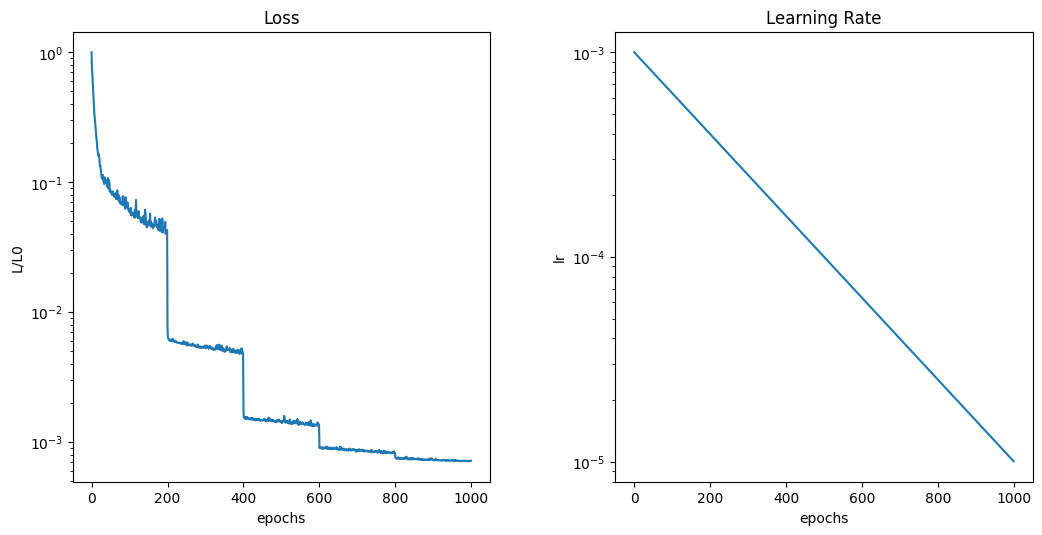

In [9]:
# ----------------- Plotting loss function -----------------
if train:
    loss = H.history["loss"]
    learning_rate = H.history["lr"]

    def cust_semilogx(AX, X, Y, xlabel, ylabel, title):
        if X is None:
            im = AX.semilogy(Y)
        else:
            im = AX.semilogy(X, Y)
        if xlabel is not None: AX.set_xlabel(xlabel)
        if ylabel is not None: AX.set_ylabel(ylabel)
        if title is not None: AX.set_title(title)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    cust_semilogx(ax[0], None, np.array(loss) / loss[0], "epochs", "L/L0", "Loss")
    cust_semilogx(ax[1], None, np.array(learning_rate), "epochs", "lr", "Learning Rate")

    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig('Epochs_2D.png',dpi=600)
    plt.show()

In [10]:
# Define the evaluation grid
N = 50
Nt = 1000
zs = np.linspace(y_min, y_max, N)
xs = np.linspace(x_min, x_max, N)
ts = np.linspace(t_min, t_max, Nt)

### PINN and Exact Solution

In [11]:
# Load exact solution file
save_directory = r'C:\Users\Umar\OneDrive\UROP_PINNs\Terzaghi\Forward\Data'

u_loaded = np.load(os.path.join(save_directory, f'2D_data_50.npy'))

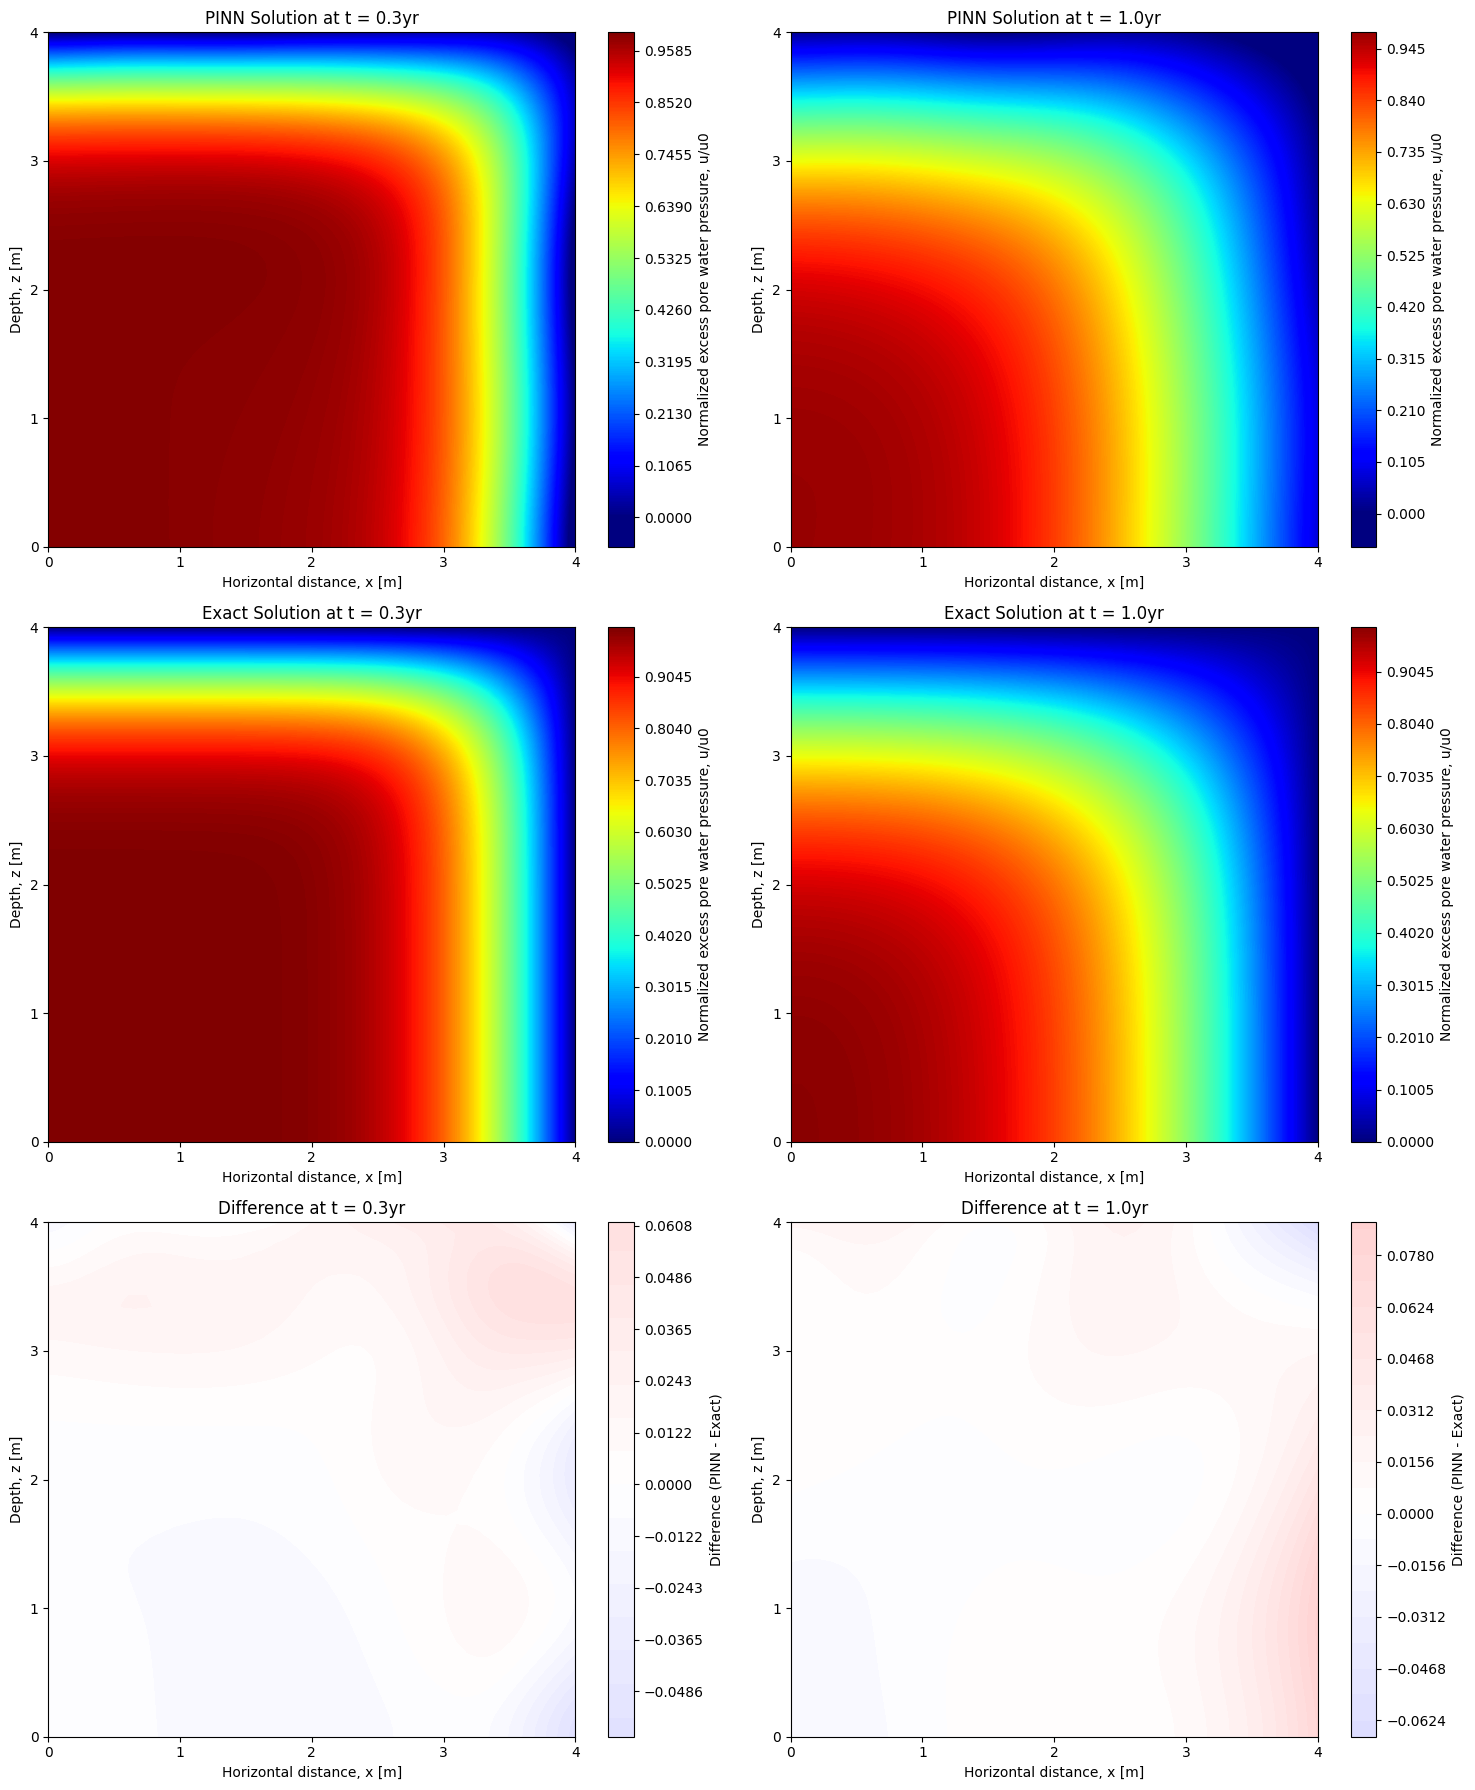

In [12]:
ZTest, XTest = np.meshgrid(zs, xs, indexing='ij')

# Select the specific time points for plotting
time_points = [0.3, 1.0]
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

for i, time_point in enumerate(time_points):
    time_index = int((time_point - t_min) / (t_max - t_min) * (Nt - 1))
    input_test = [ZTest.flatten(), XTest.flatten(), np.full_like(XTest.flatten(), ts[time_index])]
    
    # Evaluate model predictions at the specific time point
    p_pred_fixed_time = pd.eval(input_test).reshape(XTest.shape)
    
    # Exact solution at the specific time point
    u_exact_fixed_time = u_loaded[:, :, time_index]

    # Difference between PINN and exact solution
    diff_fixed_time = p_pred_fixed_time - u_exact_fixed_time

    # Plot PINN solution
    c0 = axes[0, i].contourf(XTest, ZTest, p_pred_fixed_time, levels=900, cmap='jet', vmin=0, vmax=1)
    fig.colorbar(c0, ax=axes[0, i], label='Normalized excess pore water pressure, u/u0')
    axes[0, i].set_title(f'PINN Solution at t = {time_point}yr')
    axes[0, i].set_xlabel('Horizontal distance, x [m]')
    axes[0, i].set_ylabel('Depth, z [m]')
    axes[0, i].invert_yaxis()
    axes[0, i].set_xlim(0, 4)
    axes[0, i].set_ylim(0, 4)
    axes[0, i].set_xticks(np.arange(0, 5, 1))
    axes[0, i].set_yticks(np.arange(0, 5, 1))

    # Plot exact solution
    c1 = axes[1, i].contourf(XTest, ZTest, u_exact_fixed_time, levels=900, cmap='jet', vmin=0, vmax=1)
    fig.colorbar(c1, ax=axes[1, i], label='Normalized excess pore water pressure, u/u0')
    axes[1, i].set_title(f'Exact Solution at t = {time_point}yr')
    axes[1, i].set_xlabel('Horizontal distance, x [m]')
    axes[1, i].set_ylabel('Depth, z [m]')
    axes[1, i].invert_yaxis()
    axes[1, i].set_xlim(0, 4)
    axes[1, i].set_ylim(0, 4)
    axes[1, i].set_xticks(np.arange(0, 5, 1))
    axes[1, i].set_yticks(np.arange(0, 5, 1))

    # Plot difference
    c2 = axes[2, i].contourf(XTest, ZTest, diff_fixed_time, levels=900, cmap='seismic', vmin=-1, vmax=1)
    fig.colorbar(c2, ax=axes[2, i], label='Difference (PINN - Exact)')
    axes[2, i].set_title(f'Difference at t = {time_point}yr')
    axes[2, i].set_xlabel('Horizontal distance, x [m]')
    axes[2, i].set_ylabel('Depth, z [m]')
    axes[2, i].invert_yaxis()
    axes[2, i].set_xlim(0, 4)
    axes[2, i].set_ylim(0, 4)
    axes[2, i].set_xticks(np.arange(0, 5, 1))
    axes[2, i].set_yticks(np.arange(0, 5, 1))
    
plt.tight_layout()
plt.savefig("2DContourVsExact.png", dpi=600)
plt.show()

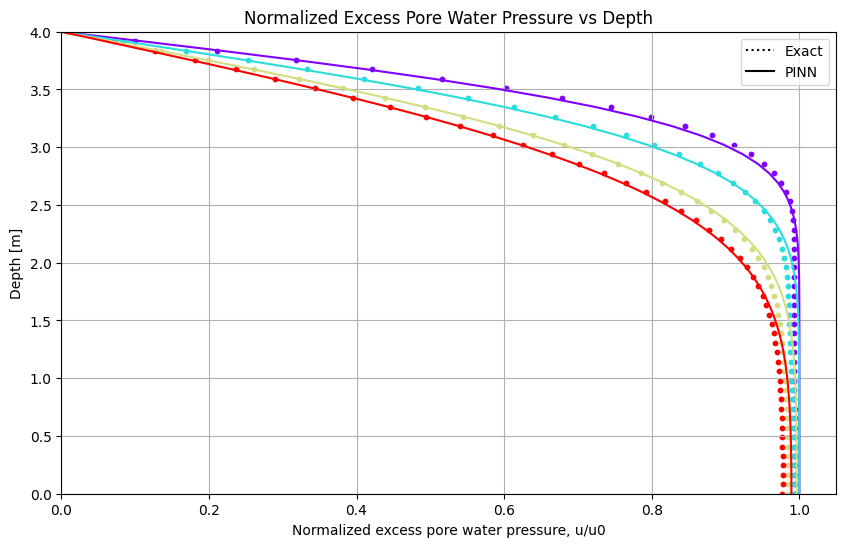

In [13]:
from matplotlib.lines import Line2D

# Plot settings
legend_settings = {
    'bbox_to_anchor': (1.25, 0.25),
    'loc': 'upper left',
    'fontsize': 'medium',
    'fancybox': True,
    'frameon': False
}

# Define the new evaluation grid for line plot
time_points = [0.3, 0.5, 0.8, 1.0]
time_indices = [int((t - t_min) / (t_max - t_min) * (Nt - 1)) for t in time_points]

p_pred_line = np.zeros((N, len(time_points)))
for i, t_idx in enumerate(time_indices):
    input_line = [zs, np.full(zs.shape, ts[t_idx])]
    p_pred_line[:, i] = pd.eval([input_line[0], np.zeros_like(input_line[0]), input_line[1]])

# Plotting normalized pore pressure and exact solution with same line colors
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(time_points)))  # Use a colormap for consistent colors

for i, (t, color) in enumerate(zip(time_points, colors)):
    ax.scatter(p_pred_line[:, i], zs, s=10, color=color)
    ax.plot(u_loaded[:, 0, time_indices[i]], zs, '-', label=f't={t:.1f}', color=color)  # Assuming we're plotting the first spatial dimension

# Setting labels and titles
ax.set_xlabel('Normalized excess pore water pressure, u/u0')
ax.set_ylabel('Depth [m]')
ax.set_title('Normalized Excess Pore Water Pressure vs Depth')

# Custom legend
legend_elements = [Line2D([0], [0], color='black', linestyle=':', label='Exact'),
                   Line2D([0], [0], color='black', linestyle='-', label='PINN')]

ax.legend(handles=legend_elements, loc='best')
ax.grid(True)

# Plot limits
plt.xlim(0, 1.05)
plt.ylim(0, 4.0)
plt.xticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(0, 4.1, 0.5))

plt.savefig('PressureFixedTime.png', dpi=600)
plt.show()